In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ecgdetectors import Detectors

In [2]:
min_max = lambda x: (x - x.min()) / (x.max() - x.min())

In [3]:
ecg = []
with open('/home/david/Documents/ECG_delineation/Delineation_ECG/wetransfer_ecgs_2024-09-09_1340/377-Bruno/Estudio.vak', 'r') as f:
    lines = f.readlines()
    for line in lines:
        ecg.append([x for x in line.split()])

ecg_x = np.asarray([np.float32(x[0].split(',')[0]) for x in ecg[1:]], dtype=np.float32)
# ecg_2 = np.asarray([np.float32(x[0].split(',')[2]) for x in ecg[1:]], dtype=np.float32)
ecg_2 = np.asarray([np.float32(x[2]) for x in ecg[1:]], dtype=np.float32)
bruno_marks = np.loadtxt('Serie_Bruno.txt', dtype=int)
# extract just T marks, which are every third mark starting from index 0
t_indexes = np.arange(2, len(bruno_marks)+2, 3)
t_indexes = bruno_marks[t_indexes]
ecg_2 = ecg_2[:t_indexes[-1] + 100]
ecg_2 = min_max(ecg_2)
ecg_x = ecg_x[:t_indexes[-1] + 100]
ecg_x = ecg_x - ecg_x[0]

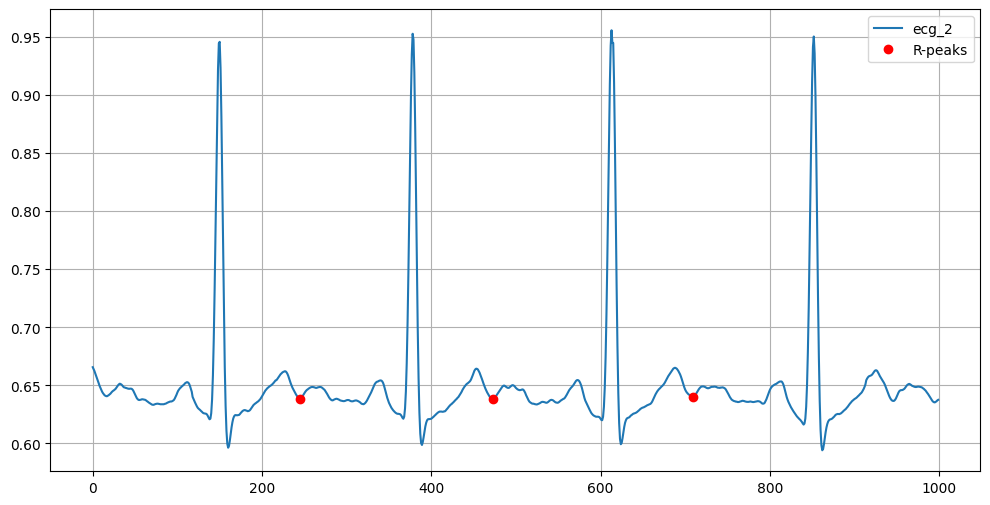

In [4]:

plt.figure(figsize=(12,6))
plt.plot(ecg_x[:1000], ecg_2[:1000], label='ecg_2')
plt.plot(ecg_x[t_indexes[:3]], ecg_2[t_indexes[:3]], 'ro', label='R-peaks')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
labels = np.zeros(len(ecg_2), dtype=int)
# fill labels with 1s +- 3 samples around each T mark
for t in t_indexes:
    labels[max(0, t-3):min(len(labels), t+4)] = 1



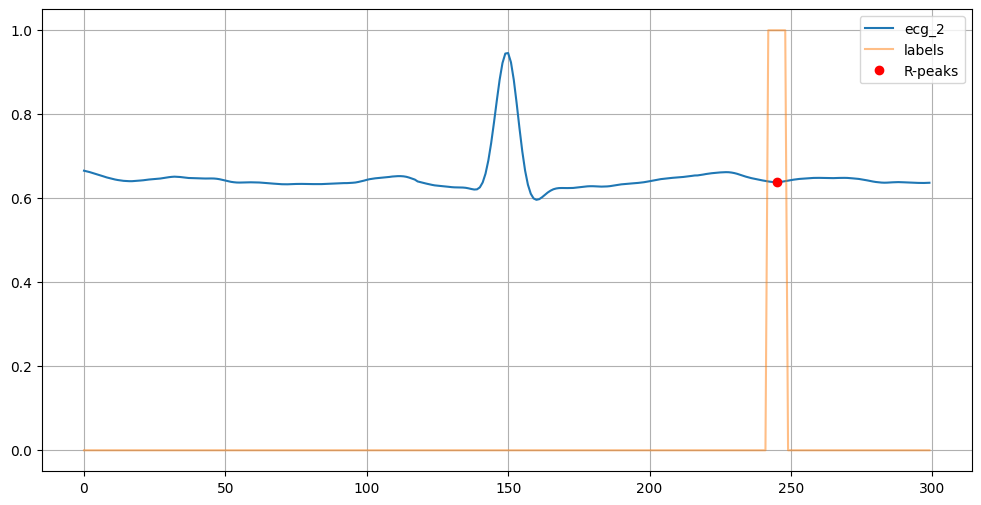

In [7]:

plt.figure(figsize=(12,6))
plt.plot(ecg_x[:300], ecg_2[:300], label='ecg_2')
plt.plot(ecg_x[:300], labels[:300], label='labels', alpha=0.5)
plt.plot(ecg_x[t_indexes[:1]], ecg_2[t_indexes[:1]], 'ro', label='R-peaks')
plt.legend()
plt.grid(True)
plt.show()